In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
os.chdir('/u/eboix/moe_experiment')
# os.chdir('/Users/eboix/Documents/local_work/moe_granularity_separation')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define MLP (used for both standalone model and MoE experts)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Define MoE with Top-K (where each expert is an MLP)
class MoE_TopK(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts, k, hidden_dim=32,bias=False):
        super().__init__()
        self.num_experts = num_experts
        self.k = k  # Number of selected experts

        # Gating network
        self.gate = nn.Linear(input_dim, num_experts,bias=bias)

        self.expert_tally = nn.Parameter(torch.zeros(self.num_experts))
        self.expert_tally.requires_grad = False

        # Expert networks (each expert is an MLP)
        self.experts = nn.ModuleList([MLP(input_dim, output_dim, hidden_dim) for _ in range(num_experts)])

    def forward(self, x):
        gate_scores = self.gate(x)  # (batch_size, num_experts) 
        topk_vals, topk_idxs = torch.topk(gate_scores, self.k, dim=-1)  # Get top-k expert indices
        # print(topk_idxs.shape)
        # Count the number of occurrences of each index in topk_idxs
        # unique_idxs, counts = torch.unique(topk_idxs, return_counts=True)
        # print(unique_idxs)
        # print(counts)
        # print(self.expert_tally)
        # self.expert_tally[unique_idxs] += counts
        # print('before',self.expert_tally)
        # print(topk_idxs.shape)
        # for i in range(topk_idxs.shape[0]):
        #     for j in range(topk_idxs.shape[1]):
        #         print(i,j)
        #         self.expert_tally[topk_idxs[j]] += 1
        # print('after',self.expert_tally)
        topk_weights = torch.softmax(topk_vals, dim=-1)  # Normalize weights over top-k

        batch_size, _ = x.shape
        expert_outputs = torch.stack([self.experts[i](x) for i in range(self.num_experts)], dim=1)  # (batch_size, num_experts, output_dim)
        selected_expert_outputs = torch.gather(expert_outputs, 1, topk_idxs.unsqueeze(-1).expand(-1, -1, expert_outputs.shape[-1]))

        output = torch.sum(selected_expert_outputs * topk_weights.unsqueeze(-1), dim=1)
        return output

# Generate data from a teacher model
def generate_teacher_data(teacher_model, n_samples=1000, input_dim=10):
    X = torch.randn(n_samples, input_dim).to(device)
    Y = teacher_model(X).detach()
    return X, Y

# Training function
def train(model, train_loader, criterion, optimizer, num_epochs=20):
    model.to(device)
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to GPU
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch) * output.shape[1]
            loss.backward()
            optimizer.step()

        # if epoch % 1 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return loss.item()

# Evaluation function
def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to GPU
            output = model(x_batch)
            total_loss += criterion(output, y_batch).item() * output.shape[1]

    # print(f"Test Loss: {total_loss / len(test_loader):.4f}")
    model.train()
    return total_loss / len(test_loader)

def evaluate_zero(test_loader):
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to GPU
            output = torch.zeros_like(y_batch)
            total_loss += criterion(output, y_batch).item() * output.shape[1]

    # print(f"Test Loss: {total_loss / len(test_loader):.4f}")
    return total_loss / len(test_loader)
    evaluate_zero(test_loader)



Using device: cuda


In [2]:
import pickle
from tqdm import tqdm
import math
def generate_datapoint(d,
                       k1,num_experts1,active_neurons1,
                       k2,num_experts2,active_neurons2,
                       num_epochs,lr,batch_size,
                       trial,
                       bias=False):
    input_dim = d
    output_dim = d
    hidden_dim1 = active_neurons1 // k1
    hidden_dim2 = active_neurons2 // k2
    active_neurons1 = hidden_dim1 * k1
    active_neurons2 = hidden_dim2 * k2
    assert(hidden_dim1 * k1 == active_neurons1)
    assert(hidden_dim2 * k2 == active_neurons2)
    if bias:
        bias_str = '_bias'
    else:
        bias_str = ''
    filename = f'd{d}_{num_experts1}e{k1}a{active_neurons1}s_{num_experts2}e{k2}a{active_neurons2}s{bias_str}_lr{lr}_b{batch_size}_e{num_epochs}_trial{trial}.pkl'
    experiment_filename = 'experiment_data/' + filename
    if not os.path.exists('experiment_data'):
        os.makedirs('experiment_data')
    if os.path.exists(experiment_filename):
        print(f'Experiment file {experiment_filename} already exists. Loading data.')
        data = pickle.load(open(experiment_filename, 'rb'))
        return data
    else:
        # return {'train_losses': [-1], 'test_losses': [math.inf], 'base_losses': [1]}
        print(f'Generating teacher model with {k1} / {num_experts1} experts and {active_neurons1} active neurons')
        # Generate dataset using the teacher model
        teacher_model = MoE_TopK(input_dim, output_dim, num_experts1, k1, hidden_dim1).to(device)


        # Train MoE_TopK with cosine decay learning rate
        print(f'Training student model with {k2} / {num_experts2} experts and {active_neurons2} active neurons')
        student_model = MoE_TopK(input_dim, output_dim, num_experts2, k2, hidden_dim2,bias=bias).to(device)
        base_optimizer = optim.AdamW([
            {'params': student_model.gate.parameters(), 'lr' : lr},  # Gate parameters
            {'params': student_model.experts.parameters(), 'lr' : lr}  # Expert parameters
        ])

        # Define a cosine annealing scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(base_optimizer, T_max=num_epochs)

        train_losses = []
        test_losses = []
        base_losses = []

        for epoch in tqdm(range(num_epochs)):
            print(f'Generating train and test for epoch {epoch}')
            X_train, Y_train = generate_teacher_data(teacher_model, n_samples=2**18, input_dim=input_dim)
            X_test, Y_test = generate_teacher_data(teacher_model, n_samples=2**12, input_dim=input_dim)
            train_dataset = TensorDataset(X_train, Y_train)
            test_dataset = TensorDataset(X_test, Y_test)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            train_loss = train(student_model, train_loader, nn.MSELoss(), base_optimizer, 1)
            test_loss = evaluate(student_model, test_loader)
            base_loss = evaluate_zero(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            base_losses.append(base_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Base Loss: {base_loss:.4f}")
            scheduler.step()  # Update learning rate
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'base_losses': base_losses,
        }
        pickle.dump(data, open(experiment_filename, 'wb'))
        return data


# Sparsity 0.5, d = active neurons. 25% overparametrized student

Experiment file experiment_data/d256_4e2a256s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_4e2a256s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_12e6a252s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_12e6a252s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_20e10a250s_4e2a320s_lr0.001_b2048_e100_tria

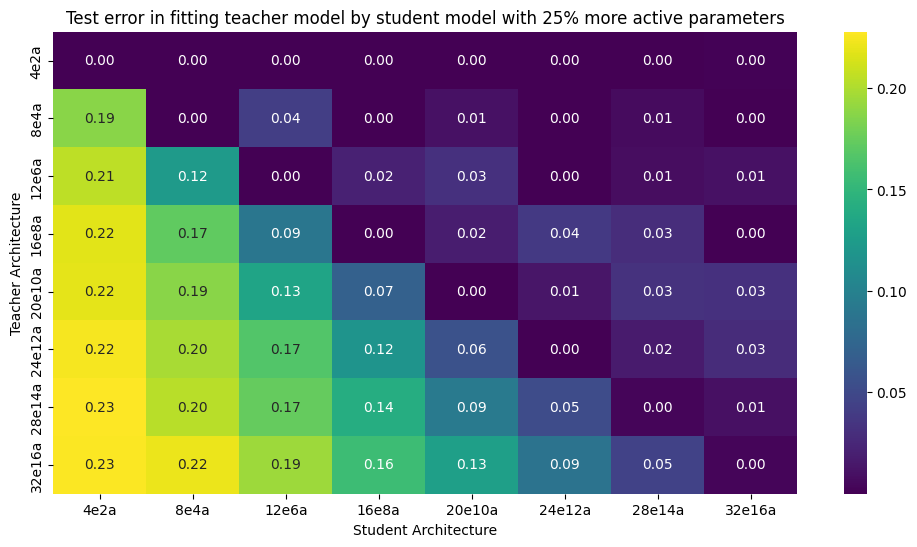

/tmp/ipykernel_1635483/3357486074.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


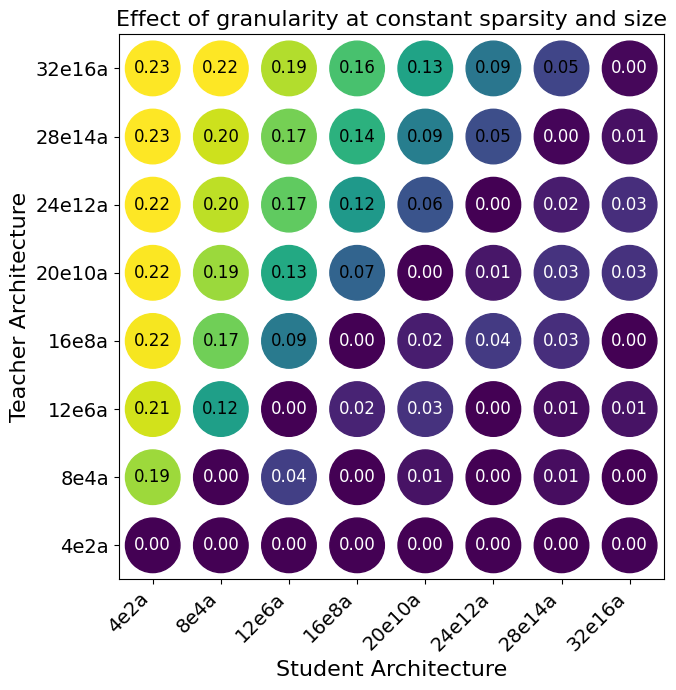

In [14]:
# Factor of 1.25 overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 320

batch_size = 2048
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
for num_experts2, k2 in [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]:
    for num_experts1, k1 in [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial}')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0)
                    # val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    val = min([datum['test_losses'][i] / datum['base_losses'][i] for i in range(len(datum['test_losses']))])
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr
            
import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]
teacher_labels = [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

# print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

# print(heatmap_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.T, annot=True, fmt=".2f", cmap="viridis") # , cbar_kws={'label': 'Test error'}
plt.title("Test error in fitting teacher model by student model with 25% more active parameters")
plt.xlabel("Student Architecture")
plt.ylabel("Teacher Architecture")
plt.gcf().set_size_inches(12, 6)
plt.show()



import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

# Data from the image (test errors)
# data = np.array([
#     [0.00, 0.00, 0.00, 0.00],
#     [0.19, 0.00, 0.00, 0.00],
#     [0.22, 0.17, 0.00, 0.00],
#     [0.23, 0.22, 0.16, 0.00],   
# ])

data = raw_data
data = np.array(data).T

rows, cols = data.shape
labels_x = [f'{label[0]}e{label[1]}a' for label in student_labels]
labels_y = [f'{label[0]}e{label[1]}a' for label in teacher_labels]
labels_y = labels_y[::-1]  # Reverse the y-axis labels

fig, ax = plt.subplots(figsize=(7, 7))  # Increased figure size for better spacing
norm = Normalize(vmin=0, vmax=0.22)
cmap = get_cmap("viridis")

# Plot grid of circles
for i in range(rows):
    for j in range(cols):
        val = data[i, j]
        color = cmap(norm(val))
        text_color = 'black' if norm(val) > 0.2 else 'white'
        circle = patches.Circle((j, rows - i - 1), 0.4, color=color)
        ax.add_patch(circle)
        ax.text(j, rows - i - 1, f"{val:.2f}", ha='center', va='center', color=text_color, fontsize=12)

# Set axes
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(-0.5, rows - 0.5)
ax.set_xticks(range(cols))
ax.set_yticks(range(rows))
ax.set_xticklabels(labels_x, fontsize=14, rotation=45, ha='right')  # Adjusted font size and rotation
ax.set_yticklabels(labels_y, fontsize=14)
ax.set_xlabel("Student Architecture", fontsize=16)  # Increased font size
ax.set_ylabel("Teacher Architecture", fontsize=16)  # Increased font size
ax.set_title("Effect of granularity at constant sparsity and size", fontsize=16)  # Increased font size and bold title
ax.set_aspect('equal')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('granularity_separation1.pdf',bbox_inches='tight')
plt.show()



# Learn 16e8a model with different granularities

Experiment file experiment_data/d256_16e8a256s_4e2a320s_bias_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_4e2a320s_bias_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_8e2a320s_bias_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_8e2a320s_bias_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_16e2a320s_bias_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_16e2a320s_bias_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_32e2a320s_bias_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_32e2a320s_bias_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/

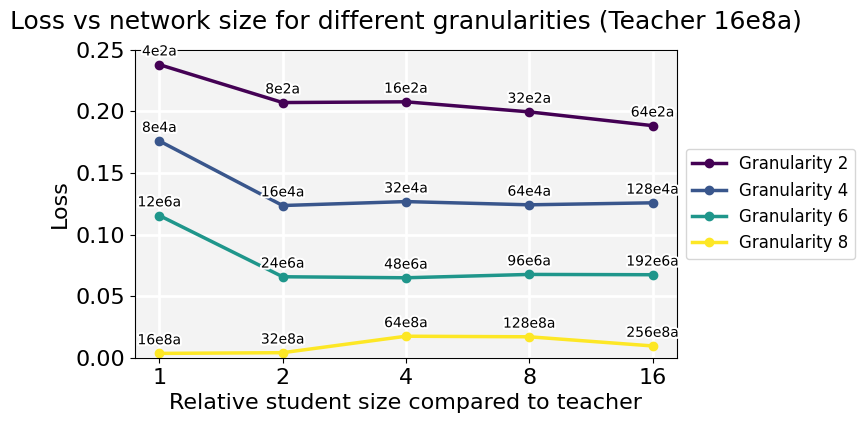

In [32]:
# Factor of 25% overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 320

batch_size = 2048
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
# for num_experts2, k2 in [(64,16),(32,8), (16,4), (8,2)]:
#     for num_experts1, k1 in [(64,16),(32,8),(16,4),(8,2)]:
student_configs = []
for granularity in [2,4,6,8]: 
    for sparsity in [2,4,8,16,32]:
        student_configs.append((sparsity*granularity,granularity))

for num_experts2, k2 in student_configs:
    for num_experts1, k1 in [(16,8)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial} \
                        --bias')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0,
                                    bias=True)
                    # val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    val = min([datum['test_losses'][i] / datum['base_losses'][i] for i in range(len(datum['test_losses']))])
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr


import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = student_configs
teacher_labels = [(16,8)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        print((student,teacher))
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

print(heatmap_df)


plt.figure(figsize=(7,4))
plt.title('Loss vs network size for different granularities (Teacher 16e8a)')
plt.xlabel('Relative student size compared to teacher', fontsize=16)
# viridis color palette for plots
colors = ['#440154ff', '#39568cff', '#1f968bff', '#fde725ff']
# Label the markers with granularity values
for idx, granularity in enumerate([2, 4, 6, 8]):
    for relsize, x in enumerate([1, 2, 4, 8, 16]):
        y = processed_data_dict[((16, 8), (2 * x * granularity, granularity))]
        # plt.text(
        #     x+0.002, y, f'{x*2*granularity}e{granularity}a', fontsize=10, color='black', ha='center', va='bottom'
        # )
        # Add a translucent background box to the text
        # plt.text(
        #     x + 0.002, y, f'{x*2*granularity}e{granularity}a', fontsize=10, color='black',
        #     ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1')
        # )
        # Add a contour around the text instead of a bounding box
        import matplotlib.patheffects as patheffects
        plt.text(
            x, y + 0.005, f'{x*2*granularity}e{granularity}a', fontsize=10, color='black',
            ha='center', va='bottom', path_effects=[
            plt.matplotlib.patheffects.withStroke(linewidth=3, foreground='white')
            ]
        )
for idx, granularity in enumerate([2, 4, 6, 8]):
    plt.plot(
        [1, 2, 4, 8, 16],
        [
            processed_data_dict[((16, 8), (2 * relsize * granularity, granularity))]
            for relsize in [1, 2, 4, 8, 16]
        ],
        label=f"Granularity {granularity}",
        color=colors[idx],
        linewidth=2.5,  # Make lines thicker
        marker='o',  # Add circle markers
        markersize=6  # Slightly smaller marker size
    )
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Loss', fontsize=16)

# Set light grey background
plt.gca().set_facecolor('#f3f3f3')
plt.ylim(0, 0.25)
# Adjust gridlines to be white and slightly thicker
plt.grid(True, which='both', color='white', linestyle='-', linewidth=2)
plt.xscale('log')
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16], fontsize=16)
plt.yticks(fontsize=16)

# grid lines
# x grid lines should go on ticks
plt.gca().xaxis.set_major_locator(plt.FixedLocator([1, 2, 4, 8, 16]))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().xaxis.set_minor_locator(plt.FixedLocator([1, 2, 4, 8, 16]))
plt.gca().xaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.title('Loss vs network size for different granularities (Teacher 16e8a)', fontsize=18,pad=15)
plt.savefig('granularity_separation2.pdf', bbox_inches='tight')
plt.show()

# Sparsity 0.5, d = active neurons. 12.5% overparametrized student

Experiment file experiment_data/d256_4e2a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_4e2a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_32e16a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_32e16a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_4e2a256s_4e2a288s_lr0.001

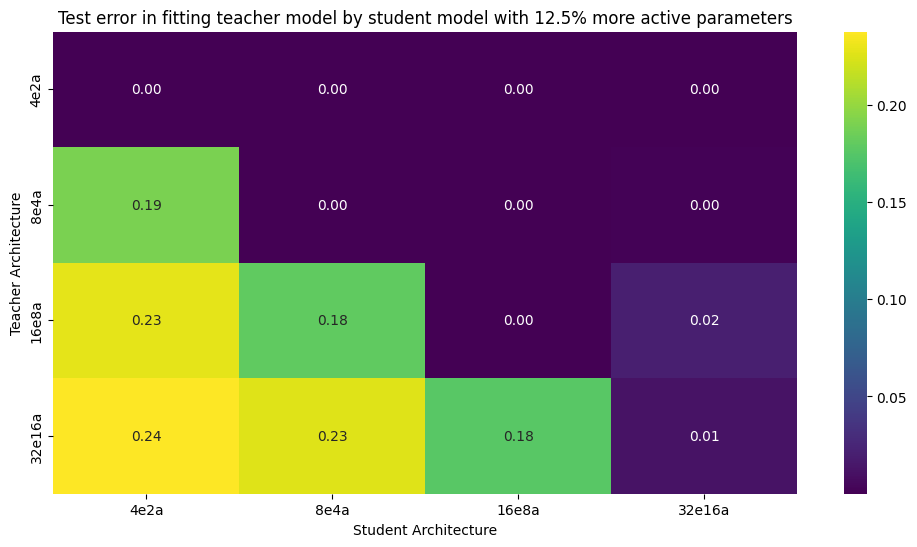

In [6]:
# Factor of 1.125 overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 288

batch_size = 2048
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
for num_experts2, k2 in [(32,16), (4,2), (8,4), (16,8)]:
    for num_experts1, k1 in [(4,2), (8,4), (16,8), (32,16)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial}')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0)
                    # val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    val = min([datum['test_losses'][i] / datum['base_losses'][i] for i in range(len(datum['test_losses']))])
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr


import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = [(4,2), (8,4), (16,8), (32,16)]
teacher_labels = [(4,2), (8,4), (16,8), (32,16)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

print(heatmap_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.T, annot=True, fmt=".2f", cmap="viridis") # , cbar_kws={'label': 'Test error'}
plt.title("Test error in fitting teacher model by student model with 12.5% more active parameters")
plt.xlabel("Student Architecture")
plt.ylabel("Teacher Architecture")
plt.gcf().set_size_inches(12, 6)
plt.show()



